## Note: This Notebook is the old version v1.0 (same as in our WACV 2025 paper)
## v1.1 is slightly different. 

In [ ]:
## Enviroment Setup
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Set the visible CUDA, here we use the second GPU
WORKING_DIR = '/home/peizhi/Documents/gaussian-dejavu/'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())
sys.path.append(WORKING_DIR)
sys.path.append('./models')
sys.path.append('./networks')
sys.path.append('./utils')
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/diff-gaussian-rasterization')
sys.path.append('./utils/gaussian_renderer')
sys.path.append('./utils/scene')
sys.path.append('./utils/arguments')
sys.path.append('./utils/simple-knn')

import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import numpy as np
import cv2
import torch

from dejavu import GaussianDejavu
from utils.personal_video_utils import *

def min_max_normalize(image):
    norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_image

dejavu = GaussianDejavu(network_weights='./models/dejavu_network.pt', uv_map_size=120, num_expressions=20)
device = dejavu.device

Current Working Directory:  /home/peizhi/Desktop/DejaVu/GaussianDejaVu
creating the FLAME Decoder


/home/peizhi/Desktop/DejaVu/GaussianDejaVu/utils/flame_lib/FLAME.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/home/peizhi/Desktop/DejaVu/GaussianDejaVu/utils/flame_lib/FLAME.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))


Framework v3.1 initialized.
Number of Gaussians:  10694
model loaded from:  ./network.pt
Gaussian DejaVu Framework Created.


/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./models/head_template2.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


## Personal Data Loader

Number of frames: 3077.
img torch.Size([3, 512, 512, 3])
parsing (3, 512, 512)
vertices (3, 5023, 3)
shape torch.Size([3, 100])
exp torch.Size([3, 50])
pose torch.Size([3, 6])
eye_pose torch.Size([3, 6])
tex torch.Size([3, 50])
light torch.Size([3, 9, 3])
cam torch.Size([3, 6])
img_masked torch.Size([3, 512, 512, 3])
masks torch.Size([3, 512, 512, 1])


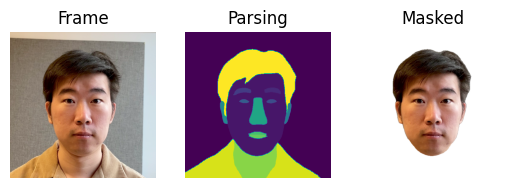

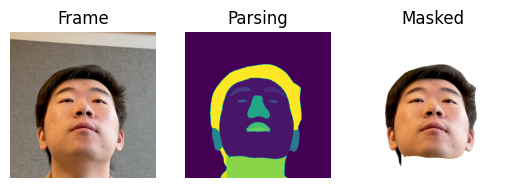

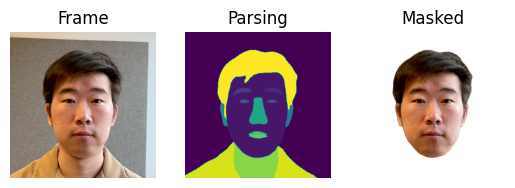

In [2]:
# Please first follow the flame-head-tracker to reconstruct the FLAME parameters  
# https://github.com/PeizhiYan/flame-head-tracker

dataset_path = '/mnt/data3_hdd/peizhi/Datasets/Personal_Videos_flame_new/peizhi-demo'
personal_dataloader = PersonalDataLoader(dataset_path=dataset_path, device=device, shuffle=True)

batch_data = personal_dataloader.next_random_batch(batch_size=3)

for key in batch_data:
    try:
        print(key, batch_data[key].shape)
    except:
        pass

for i in range(len(batch_data['fid'])):    
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(batch_data['img'][i].detach().cpu()); plt.axis('off'); plt.title('Frame')
    plt.subplot(1,3,2)
    plt.imshow(batch_data['parsing'][i]); plt.axis('off'); plt.title('Parsing')
    plt.subplot(1,3,3)
    plt.imshow(batch_data['img_masked'][i].detach().cpu()); plt.axis('off'); plt.title('Masked')
    plt.show()



## Initialize UV offsets

/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


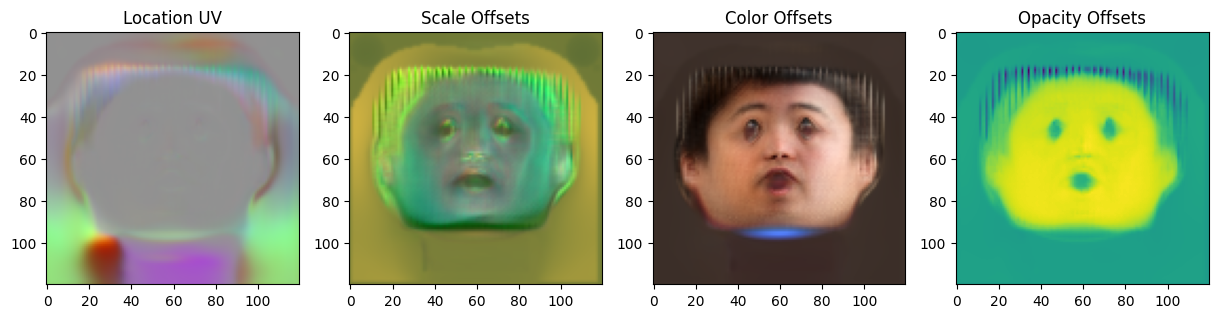

In [5]:
dejavu._compute_average_uv_offsets_(personal_dataloader, batch_size=50) # change batch size based on GPU's vRAM

plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.imshow(min_max_normalize((dejavu.mean_uv_offsets[0,:,:,:3] ).detach().cpu().numpy())); plt.title('Location UV')
plt.subplot(1,4,2)
plt.imshow(min_max_normalize(dejavu.mean_uv_offsets[0,:,:,3:6].detach().cpu().numpy())); plt.title('Scale Offsets')
plt.subplot(1,4,3)
plt.imshow(min_max_normalize(dejavu.mean_uv_offsets[0,:,:,10:13].detach().cpu().numpy())); plt.title('Color Offsets')
plt.subplot(1,4,4)
plt.imshow(min_max_normalize(dejavu.mean_uv_offsets[0,:,:,9].detach().cpu().numpy())); plt.title('Opacity Offsets')
plt.show()


## Stage 1: Global Rectification Learning

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


Loss: 0.0061 LR: 0.0024: 100%|██████████| 300/300 [03:04<00:00,  1.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


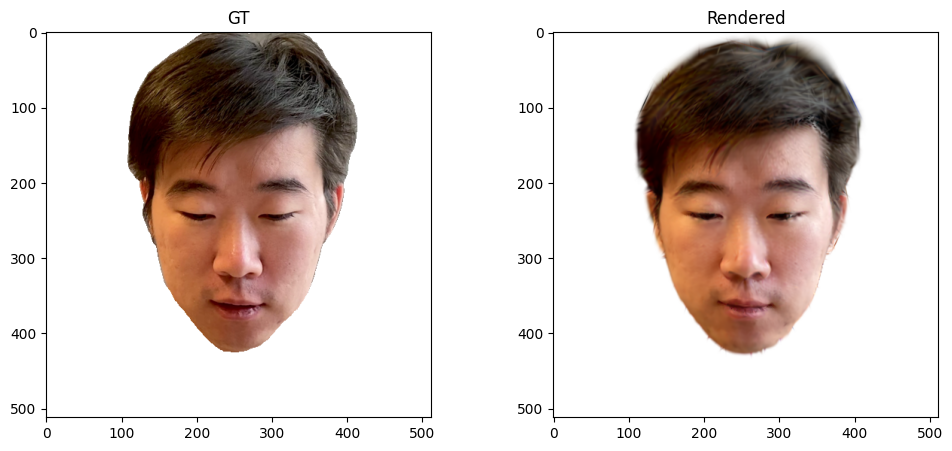

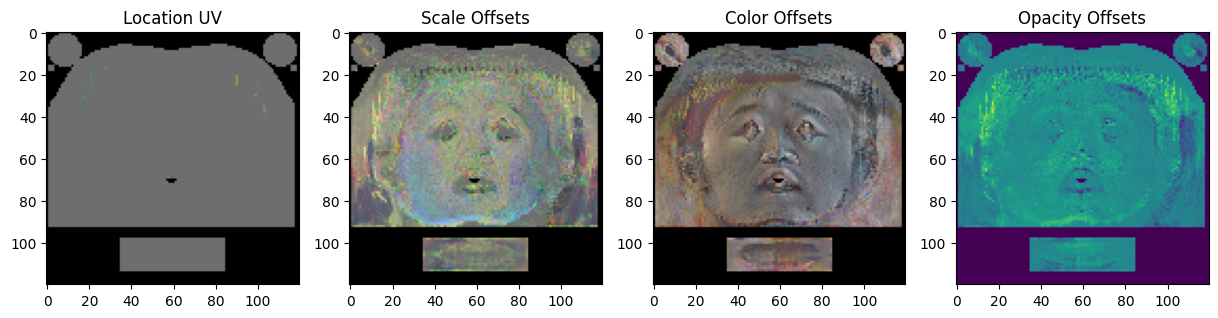

In [8]:

dejavu.train_global_offsets(personal_dataloader, batch_size=16, total_steps=300)


# render head avatar
batch_data_test = personal_dataloader.next_random_batch(vid=None, batch_size=1)
batch_rendered = dejavu._render_with_global_offsets_(batch_data_test, dejavu.global_uv_delta)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(batch_data_test['img_masked'][0].detach().cpu()); plt.title('GT')
plt.subplot(1,2,2)
plt.imshow(batch_rendered[0].permute(1,2,0).detach().cpu()); plt.title('Rendered')
plt.show()


# show global uv offsets
uv_delta_visualize = min_max_normalize(dejavu.global_uv_delta.detach().cpu().numpy()) * dejavu.framework.uv_rasterizer.uv_mask_full[None,:,:,None]
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.imshow(uv_delta_visualize[0,:,:,:3]); plt.title('Location UV')
plt.subplot(1,4,2)
plt.imshow(uv_delta_visualize[0,:,:,3:6]); plt.title('Scale Offsets')
plt.subplot(1,4,3)
plt.imshow(uv_delta_visualize[0,:,:,10:13]); plt.title('Color Offsets')
plt.subplot(1,4,4)
plt.imshow(uv_delta_visualize[0,:,:,9]); plt.title('Opacity Offsets')
plt.show()


## Stage 2: Expression-Aware Rectification Learning

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


Loss: 0.0131 LR: 0.0328: 100%|██████████| 500/500 [05:48<00:00,  1.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


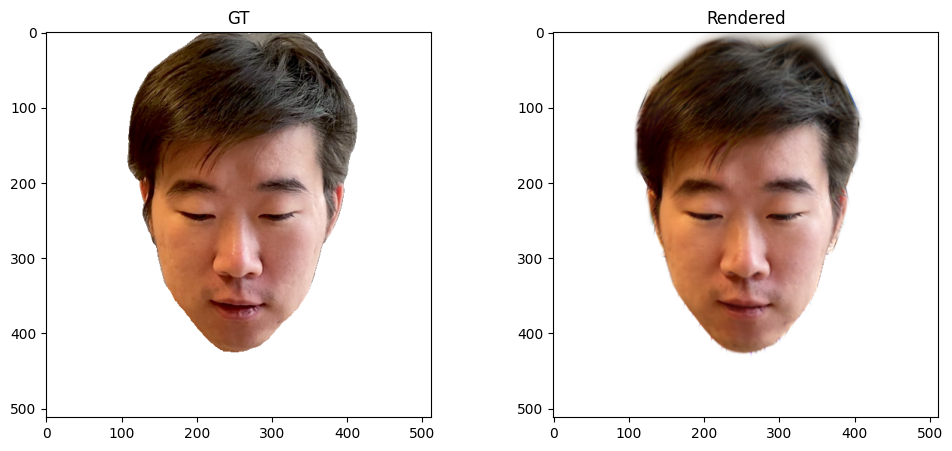

In [10]:

dejavu.train_blendmaps(personal_dataloader, batch_size=16, total_steps=500)

# render head avatar
batch_rendered, _ = dejavu._render_with_blendmaps_(batch_data_test, dejavu.uv_delta_blendmaps)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(batch_data_test['img_masked'][0].detach().cpu()); plt.title('GT')
plt.subplot(1,2,2)
plt.imshow(batch_rendered[0].permute(1,2,0).detach().cpu()); plt.title('Rendered')
plt.show()




## Compare Results

/home/peizhi/Desktop/DejaVu/GaussianDejaVu/utils/scene/cameras.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  world_view_transform = torch.tensor(cam.world_view_transform).float().to(device)
/home/peizhi/Desktop/DejaVu/GaussianDejaVu/utils/scene/cameras.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_proj_transform = torch.tensor(cam.full_proj_transform).float().to(device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats o

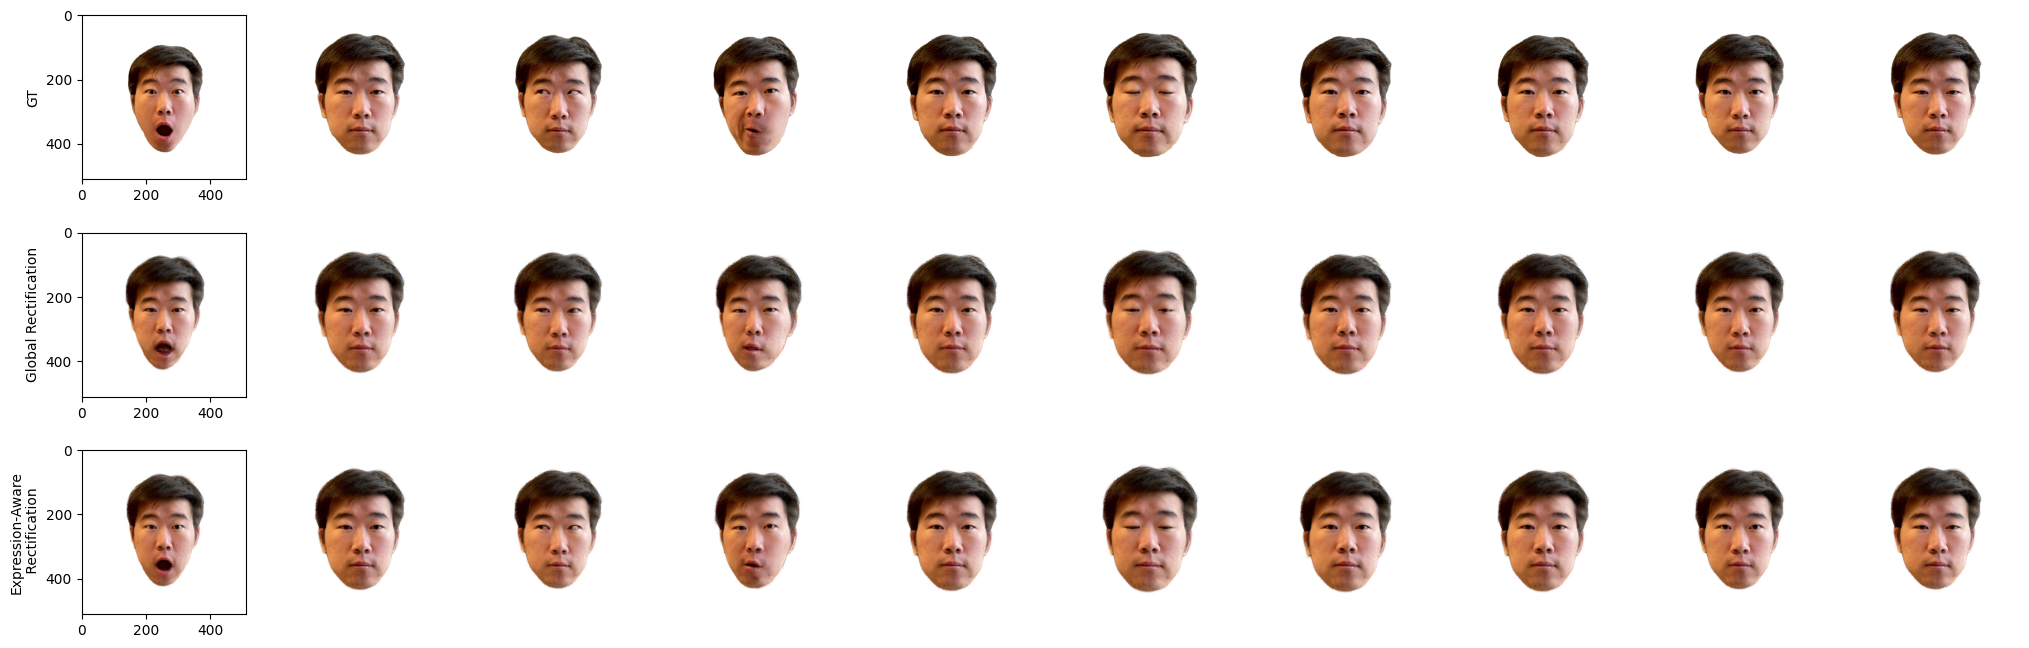

In [4]:

plt.figure(figsize=(25,8))

num_examples = 10
for i in range(num_examples):
    batch_data_test = personal_dataloader.next_random_batch(vid=None, batch_size=1)

    plt.subplot(3,num_examples,i+1)
    plt.imshow(batch_data_test['img_masked'][0].detach().cpu()); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('GT')

    plt.subplot(3,num_examples,num_examples+i+1)
    batch_rendered_global = dejavu._render_with_global_offsets_(batch_data_test, dejavu.global_uv_delta)
    plt.imshow(batch_rendered_global[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Global Rectification')

    plt.subplot(3,num_examples,2*num_examples+i+1)
    batch_rendered_blend, _ = dejavu._render_with_blendmaps_(batch_data_test, dejavu.uv_delta_blendmaps)
    plt.imshow(batch_rendered_blend[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Expression-Aware\n Rectification')

plt.show()



## Save Head Avatar

In [ ]:
# save head avatar
# dejavu.save_head_avatar(save_path='./saved_avatars', avatar_name='peizhi')


Head avatar parameters saved to ./saved_avatars


## Load Head Avatar

In [3]:
# load head avatar
dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='peizhi')


Head avatar parameters loaded
